# pegar dados

In [5]:
# abrir o dataset e transformar em um dataframe
data = []
with open('dataset.json') as f:
    for line in f:
        data.append(json.loads(line))

df = pd.DataFrame(data)
df = df[['headline', 'is_sarcastic']]

# BERT BASE UNCASED

In [ ]:
import json
import torch
import numpy as np
import pandas as pd
from datasets import load_metric, Dataset
from peft import LoraConfig, get_peft_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, Trainer, TrainingArguments

In [280]:
# dividir o dataset em treino e teste
train_df, test_df = train_test_split(df, test_size=0.2)

# Tokenizar os dados. os textos viram input IDs e as labels viram array de tensores
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_df['headline'].tolist(), padding=True, truncation=True, return_tensors='pt')
train_labels = torch.tensor(train_df['is_sarcastic'].tolist())

test_encodings = tokenizer(test_df['headline'].tolist(), padding=True, truncation=True, return_tensors='pt')
test_labels = torch.tensor(test_df['is_sarcastic'].tolist())

#transformar o dataset inteiro em lista de dicionario
# train_dataset = [{'input_ids': train_encodings['input_ids'][i], 'attention_mask': train_encodings['attention_mask'][i], 'labels': train_labels[i]} for i in range(len(train_labels))]
# test_dataset = [{'input_ids': test_encodings['input_ids'][i], 'attention_mask': test_encodings['attention_mask'][i], 'labels': test_labels[i]} for i in range(len(test_labels))]

train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask'],
    'labels': test_labels
})

# nome do modelo e quantas classificacoes a coluna das anotacoes tem (no caso desse dataset, são 2: 1 ou 0)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

# definir se vai rodar em gpu ou cpu, se não define, automaticamente roda na CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# definir os argumentos do LoRA
lora_config = LoraConfig(r=8, lora_alpha=16, lora_dropout=0.1)

# colocar o meu modelo dentro do LoRA
model = get_peft_model(model, lora_config)

# define como o treinamento deve se comportar
# training_args = TrainingArguments(
#     num_train_epochs=5,
#     per_device_train_batch_size=8,
#     weight_decay=0.01,
#     learning_rate=2e-5,
#     output_dir='./results',
#     logging_dir='./logs',
#     logging_strategy='epoch',
#     eval_strategy='epoch')

training_args = TrainingArguments(
    num_train_epochs=5,
    per_device_train_batch_size=8,
    weight_decay=0.01,
    learning_rate=2e-5,
    output_dir='./results',
    logging_dir='./logs',
    logging_strategy='epoch',
    evaluation_strategy='epoch',  # Certifique-se de que esta configuração é compatível com a versão da biblioteca
    save_strategy='epoch',  # Adicione esta linha para salvar o modelo a cada época  # Adicione esta linha para carregar o melhor modelo ao final
    report_to='tensorboard'  # Certifique-se de que o TensorBoard está configurado para logging
)

# define o Trainer, ou seja, o modelo usado, como vai se comportar e o dataset que vai ser utilizado
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()


# RoBERTa

In [339]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Dividir o dataset em treino e teste
train_df, test_df = train_test_split(df, test_size=0.2)

# Tokenizar os dados
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

train_encodings = tokenizer(train_df['headline'].tolist(), padding=True, truncation=True, max_length=512, return_tensors='pt')
train_labels = torch.tensor(train_df['is_sarcastic'].tolist())

test_encodings = tokenizer(test_df['headline'].tolist(), padding=True, truncation=True, max_length=512, return_tensors='pt')
# No need to include labels here, they will be used for evaluation after training
test_labels = torch.tensor(test_df['is_sarcastic'].tolist())

# Transformar o dataset em lista de dicionários
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': train_labels
})

test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask']
})

# Nome do modelo e número de rótulos de classificação
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=2)

# Definir se vai rodar em GPU ou CPU
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# Define LoRA configurations if needed
lora_config = LoraConfig(r=8, lora_alpha=16, lora_dropout=0.1)
model = get_peft_model(model, lora_config)

# Definir os argumentos de treinamento
training_args = TrainingArguments(
    num_train_epochs=5,
    per_device_train_batch_size=8,
    weight_decay=0.01,
    learning_rate=2e-5,
    output_dir='./results',
    logging_dir='./logs',
    logging_strategy='epoch',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    report_to='tensorboard'
)

# Definir o Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Treinar o modelo
trainer.train()




Epoch,Training Loss,Validation Loss
1,0.535200,No log
2,0.345600,No log
3,0.324800,No log
4,0.305800,No log
5,0.308400,No log


TrainOutput(global_step=13355, training_loss=0.36398506235960315, metrics={'train_runtime': 1020.1062, 'train_samples_per_second': 104.729, 'train_steps_per_second': 13.092, 'total_flos': 3746143755964560.0, 'train_loss': 0.36398506235960315, 'epoch': 5.0})

In [354]:
test_predictions = trainer.predict(test_dataset)

logits = test_predictions.predictions
print("Logits shape:", logits.shape)
print("True labels shape:", test_labels.shape)

if logits.shape[0] != len(test_labels):
    raise ValueError("Mismatch between number of logits and true labels")

predicted_labels = np.argmax(logits, axis=1)

accuracy = accuracy_score(test_df['is_sarcastic'], predicted_labels)
f1 = f1_score(test_df['is_sarcastic'], predicted_labels)

print(f'Accuracy, {accuracy:.4f}')
print(f'F1 Score, {f1:.4f}')


Accuracy, 0.8903
F1 Score, 0.8681


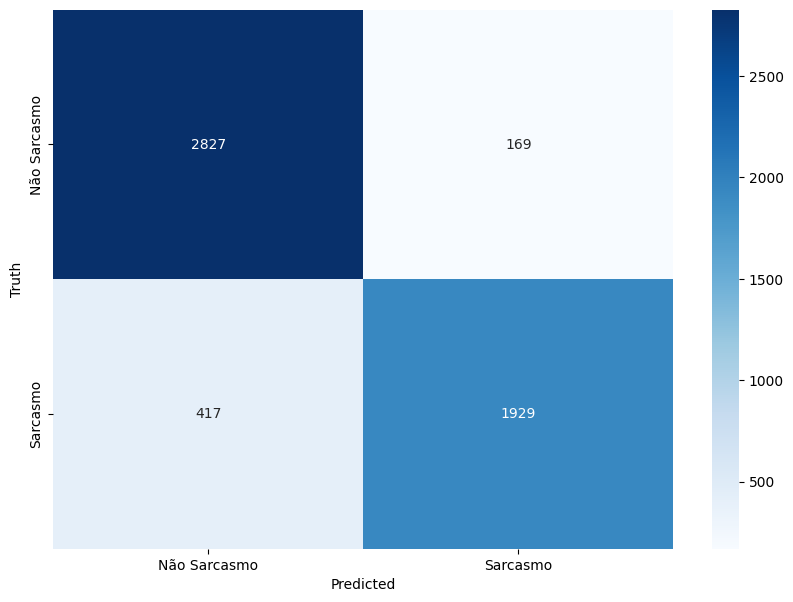

Accuracy on the test set: 0.8903032572070385
F1 Score on the test set: 0.8681368136813681


In [355]:
# Confusion Matrix
cm = confusion_matrix(test_df['is_sarcastic'], predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Sarcasmo', 'Sarcasmo'],
            yticklabels=['Não Sarcasmo', 'Sarcasmo'])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

print("Accuracy on the test set:", accuracy)
print("F1 Score on the test set:", f1)


In [410]:
# prompt: create precision and recall

from sklearn.metrics import precision_score, recall_score

precision = precision_score(test_df['is_sarcastic'], predicted_labels)
recall = recall_score(test_df['is_sarcastic'], predicted_labels)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')


Precision: 0.9194
Recall: 0.8223


# RoBERTa + LSTM + CNN

In [376]:
from transformers import RobertaTokenizer, RobertaModel, AdamW
from datasets import Dataset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset as TorchDataset
from tqdm import tqdm
from peft import LoraConfig, get_peft_model

In [398]:
from transformers import RobertaTokenizer, RobertaModel, AdamW
from datasets import Dataset
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset as TorchDataset
from tqdm import tqdm
from peft import LoraConfig, get_peft_model

# Define a custom dataset class
class SarcasmDataset(TorchDataset):
    def __init__(self, dataframe, tokenizer, max_length):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        text = row['headline']
        label = torch.tensor(row['is_sarcastic'])

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': label
        }

# Define the custom model with LoRA
class RCNNRobertaModel(nn.Module):
    def __init__(self, base_model):
        super(RCNNRobertaModel, self).__init__()
        self.roberta = base_model
        self.lstm = nn.LSTM(input_size=768, hidden_size=256, num_layers=1, bidirectional=True, batch_first=True)
        self.conv = nn.Conv1d(in_channels=512, out_channels=128, kernel_size=3, padding=1)
        self.max_pool = nn.MaxPool1d(kernel_size=2)
        self.fc = nn.Linear(128, 2)

    def forward(self, input_ids, attention_mask):
        roberta_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)[0]
        lstm_output, _ = self.lstm(roberta_output)
        lstm_output = lstm_output.permute(0, 2, 1)
        conv_output = self.conv(lstm_output)
        pooled_output = self.max_pool(conv_output)
        pooled_output = pooled_output.permute(0, 2, 1)
        logits = self.fc(pooled_output[:, -1, :])
        return logits

# Initialize tokenizer and datasets
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

train_dataset = SarcasmDataset(train_df, tokenizer, max_length=128)
test_dataset = SarcasmDataset(test_df, tokenizer, max_length=128)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# Initialize RoBERTa with LoRA
base_model = RobertaModel.from_pretrained('roberta-base')
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,
    target_modules=["query", "key", "value"]
)

lora_model = get_peft_model(base_model, lora_config)
model = RCNNRobertaModel(lora_model)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)

# Define optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# Training and evaluation functions
def train_epoch(model, data_loader, loss_fn, optimizer, device):
    model.train()
    losses = []
    correct_predictions = 0

    progress_bar = tqdm(data_loader, desc='Training', leave=False)
    for batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        progress_bar.set_postfix({'loss': loss.item()})

    train_acc = correct_predictions.double() / len(data_loader.dataset)
    train_loss = sum(losses) / len(losses)
    return train_acc, train_loss

def eval_model(model, data_loader, loss_fn, device):
    model.eval()
    losses = []
    correct_predictions = 0

    progress_bar = tqdm(data_loader, desc='Evaluating', leave=False)
    with torch.no_grad():
        for batch in progress_bar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

            progress_bar.set_postfix({'loss': loss.item()})

    val_acc = correct_predictions.double() / len(data_loader.dataset)
    val_loss = sum(losses) / len(losses)
    return val_acc, val_loss

# Training loop
EPOCHS = 5

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    train_acc, train_loss = train_epoch(model, train_loader, loss_fn, optimizer, device)
    print(f'Train loss {train_loss:.4f} accuracy {train_acc:.4f}')
    val_acc, val_loss = eval_model(model, test_loader, loss_fn, device)
    print(f'Val   loss {val_loss:.4f} accuracy {val_acc:.4f}')


Epoch 1/5


Train loss 0.3800 accuracy 0.8171


Val   loss 0.2577 accuracy 0.8952
Epoch 2/5


Train loss 0.2592 accuracy 0.8915


Val   loss 0.2268 accuracy 0.9042
Epoch 3/5


Train loss 0.2257 accuracy 0.9059


Val   loss 0.2020 accuracy 0.9174
Epoch 4/5


Train loss 0.2061 accuracy 0.9155


Val   loss 0.1860 accuracy 0.9238
Epoch 5/5


Train loss 0.1914 accuracy 0.9215


Val   loss 0.2326 accuracy 0.9047


In [401]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Define function to predict and evaluate the model
def predict_and_evaluate(model, data_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(data_loader, desc='Predicting', leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].cpu().numpy()

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels)

    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds)

    return accuracy, f1

# Make predictions and evaluate on test dataset
test_accuracy, test_f1 = predict_and_evaluate(model, test_loader, device)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')


Test Accuracy: 0.9047
Test F1 Score: 0.8827


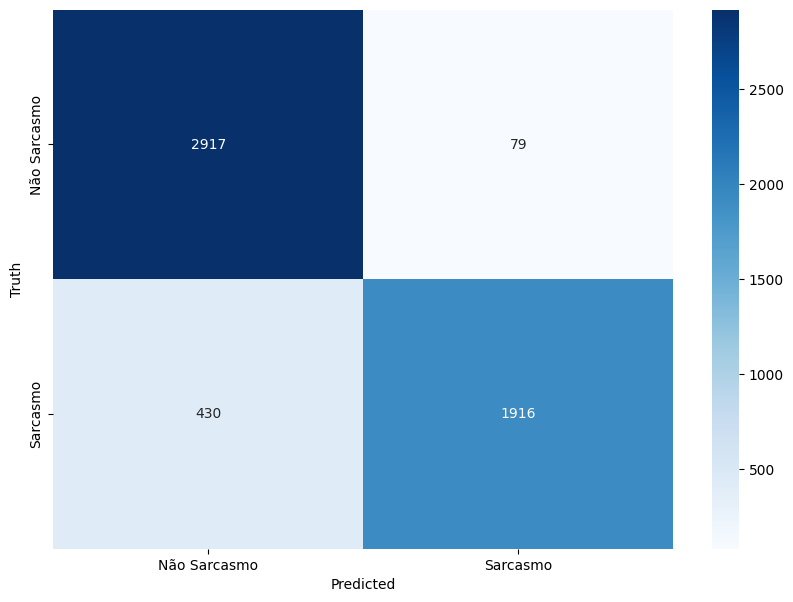

In [407]:


from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

test_accuracy, test_f1 = predict_and_evaluate(model, test_loader, device)
print(f'Test Accuracy: {test_accuracy:.4f}')
print(f'Test F1 Score: {test_f1:.4f}')

# Predict labels for the test set
model.eval()
all_preds = []
all_labels = []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Não Sarcasmo', 'Sarcasmo'],
            yticklabels=['Não Sarcasmo', 'Sarcasmo'])
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()



In [409]:
# prompt: precision and recall

from sklearn.metrics import precision_score, recall_score

# Calculate precision and recall
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')


Precision: 0.9604
Recall: 0.8167
